# Train Action-Chunking-Transformer (ACT) on your Dataset

Train the ACT model on your custom dataset. In this example, we set chunk_size as 10. 

In [15]:
# 🔧 Setup and Configuration

# Define dataset paths and configuration
import os

DATASET_ROOT = '/teamspace/studios/this_studio/.cache/huggingface/lerobot/bearlover365/red_cube_always_in_same_place/'
DATASET_NAME = os.path.basename(DATASET_ROOT.rstrip('/'))

print(f"📁 Using dataset: {DATASET_NAME}")
print(f"📂 Dataset root: {DATASET_ROOT}")


📁 Using dataset: red_cube_always_in_same_place
📂 Dataset root: /teamspace/studios/this_studio/.cache/huggingface/lerobot/bearlover365/red_cube_always_in_same_place/


In [16]:
import torch

from lerobot.common.datasets.lerobot_dataset import LeRobotDataset, LeRobotDatasetMetadata
from lerobot.common.datasets.utils import dataset_to_policy_features
from lerobot.common.policies.act.configuration_act import ACTConfig
from lerobot.common.policies.act.modeling_act import ACTPolicy
from lerobot.configs.types import FeatureType
from lerobot.common.datasets.factory import resolve_delta_timestamps
import torchvision

In [17]:
# 🔧 Additional PIL/Image Compatibility Fixes

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torchvision")

# Additional PIL fixes for mode issues in version 11.x
try:
    from PIL import Image
    import numpy as np
    
    # Ensure PIL images work correctly with matplotlib
    def safe_image_display(img_tensor):
        """Safely convert tensor to displayable format"""
        if hasattr(img_tensor, 'numpy'):
            img_array = img_tensor.numpy()
        else:
            img_array = img_tensor
            
        # Ensure correct format for matplotlib
        if img_array.shape[0] == 3:  # CHW format
            img_array = img_array.transpose(1, 2, 0)
        
        # Clip values to valid range
        img_array = np.clip(img_array, 0, 1)
        return img_array
    
    print("✅ Image compatibility functions loaded")
    
except Exception as e:
    print(f"⚠️  PIL compatibility setup warning: {e}")
    print("💡 Image display may have issues but training will still work")


✅ Image compatibility functions loaded


In [18]:
device = torch.device("cuda")

# Number of offline training steps (we'll only do offline training for this example.)
# Adjust as you prefer. 5000 steps are needed to get something worth evaluating.
training_steps = 3000
log_freq = 100

# Check for potential PIL issues and provide helpful guidance  
try:
    import PIL
    from PIL import Image
    pil_version = PIL.__version__
    print(f"📸 PIL/Pillow version: {pil_version}")
    
    # Check if we have a known problematic version
    if "10." in pil_version or "11." in pil_version:
        print("⚠️  Note: You might encounter PIL AttributeError issues with this version.")
        print("💡 Applying compatibility fixes for PIL version 11.x...")
        
        # Apply PIL compatibility fixes for version 11.x
        # Fix the mode attribute issue
        if not hasattr(Image, '_original_fromarray'):
            Image._original_fromarray = Image.fromarray
            def patched_fromarray(obj, mode=None):
                img = Image._original_fromarray(obj, mode)
                if hasattr(img, '_mode'):
                    img.mode = img._mode
                return img
            Image.fromarray = patched_fromarray
            
        print("✅ PIL compatibility patches applied!")
    else:
        print("✅ PIL version looks good!")
        
except ImportError:
    print("❌ PIL/Pillow not found - this might cause issues")
    print("💡 Consider installing: pip install pillow")
except Exception as e:
    print(f"⚠️  PIL setup issue: {e}")
    print("💡 Will attempt to work around PIL issues during execution")

📸 PIL/Pillow version: 11.1.0
⚠️  Note: You might encounter PIL AttributeError issues with this version.
💡 Applying compatibility fixes for PIL version 11.x...
✅ PIL compatibility patches applied!


## Policy Configuration and Initialize

chunk_size = 10

In [19]:
DATASET_ROOT = '/teamspace/studios/this_studio/.cache/huggingface/lerobot/bearlover365/red_cube_always_in_same_place/'

# Get name from last place between last slashes, whether there is an ending slash or not
import os

DATASET_NAME = os.path.basename(DATASET_ROOT.rstrip('/'))
print('DATASET_NAME', DATASET_NAME)

DATASET_NAME red_cube_always_in_same_place


### 📊 Dataset Inspection

Let's start by understanding our dataset. We'll check the total number of frames (steps) available for training and inspect the statistics (mean and std) for the state and action spaces. These stats were computed when the dataset was created and are crucial for normalizing the data before feeding it to the policy.


In [20]:
# Let's create a simple dataset first to inspect it (no transforms yet)
# simple_dataset = LeRobotDataset("omy_pnp", root='./demo_data')
# Use pyav backend to avoid torchcodec/FFmpeg issues
simple_dataset = LeRobotDataset(DATASET_NAME, root=DATASET_ROOT, video_backend="pyav")

print(f"🗂️  The dataset contains {len(simple_dataset)} steps of experience.")
print(f"🎯  Number of episodes: {len(simple_dataset.meta.episodes)}")

print("\n📈 Dataset statistics used for normalization:")
for key, stats in simple_dataset.meta.stats.items():
    print(f"  {key}:")
    if 'mean' in stats:
        print(f"    mean: {stats['mean']}")
        print(f"    std:  {stats['std']}")
    if 'min' in stats:
        print(f"    min:  {stats['min']}")
        print(f"    max:  {stats['max']}")
    print()

# Let's look at one sample to understand the data structure
sample = simple_dataset[0]
print("🔍 Sample data structure:")
for key, value in sample.items():
    if isinstance(value, torch.Tensor):
        print(f"  {key}: shape {value.shape}, dtype {value.dtype}")
    else:
        print(f"  {key}: {type(value)} - {value}")


🗂️  The dataset contains 6790 steps of experience.
🎯  Number of episodes: 10

📈 Dataset statistics used for normalization:
  task_index:
    mean: [0.]
    std:  [0.]
    min:  [0]
    max:  [0]

  timestamp:
    mean: [11.43964654]
    std:  [6.76881085]
    min:  [0.]
    max:  [25.83333333]

  episode_index:
    mean: [4.20206186]
    std:  [2.85400195]
    min:  [0]
    max:  [9]

  action:
    mean: [ -6.12852169 -21.64274674  -9.6670497   95.47745628  -4.07838035
   9.95026539]
    std:  [11.91286377 52.05666952 25.20177972  6.3053577   6.66790093 15.43442314]
    min:  [ -32.81985474 -100.          -60.99098969   71.98067474  -21.86192513
    0.        ]
    max:  [  7.57381248  49.29336166  25.31531525 100.           6.6422596
  49.33444214]

  observation.images.front:
    mean: [[[0.49720973]]

 [[0.48067371]]

 [[0.490151  ]]]
    std:  [[[0.17443866]]

 [[0.16232141]]

 [[0.177593  ]]]
    min:  [[[0.]]

 [[0.]]

 [[0.]]]
    max:  [[[0.90980392]]

 [[0.83529412]]

 [[1.   

In [21]:
# 🔧 Fixed Dataset Metadata Creation

# IMPORTANT: LeRobotDatasetMetadata does NOT accept video_backend parameter
# Only LeRobotDataset accepts video_backend parameter

# ✅ CORRECT way to create dataset metadata:
print("📋 Creating dataset metadata (without video_backend parameter)...")
try:
    dataset_metadata = LeRobotDatasetMetadata(DATASET_NAME, root=DATASET_ROOT)
    print("✅ Dataset metadata created successfully!")
    
    # Extract features for policy configuration  
    features = dataset_to_policy_features(dataset_metadata.features)
    output_features = {key: ft for key, ft in features.items() if ft.type is FeatureType.ACTION}
    input_features = {key: ft for key, ft in features.items() if key not in output_features}
    
    # Remove wrist_image if it exists but we don't want to use it
    if "observation.wrist_image" in input_features:
        input_features.pop("observation.wrist_image")
        print("📷 Removed wrist_image from input features")
    
    print(f"🔧 Input features: {list(input_features.keys())}")
    print(f"🎯 Output features: {list(output_features.keys())}")
    
except Exception as e:
    print(f"❌ Error creating dataset metadata: {e}")
    print("💡 Make sure DATASET_NAME and DATASET_ROOT are properly defined")
    print("⚠️  Remember: Do NOT add video_backend to LeRobotDatasetMetadata!")
    raise


📋 Creating dataset metadata (without video_backend parameter)...
✅ Dataset metadata created successfully!
🔧 Input features: ['observation.state', 'observation.images.front']
🎯 Output features: ['action']


### 🧠 Model Architecture Analysis

Next, let's instantiate our policy and analyze its complexity. The number of trainable parameters tells us about the model's capacity to learn (and overfit!).


In [22]:
# When starting from scratch (i.e. not from a pretrained policy), we need to specify 2 things before
# creating the policy:
#   - input/output shapes: to properly size the policy
#   - dataset stats: for normalization and denormalization of input/outputs
# dataset_metadata = LeRobotDatasetMetadata("omy_pnp", root='./demo_data')
dataset_metadata = LeRobotDatasetMetadata("omy_pnp", root=DATASET_ROOT)
features = dataset_to_policy_features(dataset_metadata.features)
output_features = {key: ft for key, ft in features.items() if ft.type is FeatureType.ACTION}
input_features = {key: ft for key, ft in features.items() if key not in output_features}
print('input features before', input_features)
# input_features.pop("observation.wrist_image")
# Policies are initialized with a configuration class, in this case `DiffusionConfig`. For this example,
# we'll just use the defaults and so no arguments other than input/output features need to be passed.
cfg = ACTConfig(input_features=input_features, output_features=output_features, chunk_size= 10, n_action_steps=10)
# This allows us to construct the data with action chunking
delta_timestamps = resolve_delta_timestamps(cfg, dataset_metadata)
# We can now instantiate our policy with this config and the dataset stats.
policy = ACTPolicy(cfg, dataset_stats=dataset_metadata.stats)
policy.train()
policy.to(device)

input features before {'observation.state': PolicyFeature(type=<FeatureType.STATE: 'STATE'>, shape=(6,)), 'observation.images.front': PolicyFeature(type=<FeatureType.VISUAL: 'VISUAL'>, shape=(3, 480, 640))}


ACTPolicy(
  (normalize_inputs): Normalize(
    (buffer_observation_state): ParameterDict(
        (mean): Parameter containing: [torch.cuda.FloatTensor of size 6 (cuda:0)]
        (std): Parameter containing: [torch.cuda.FloatTensor of size 6 (cuda:0)]
    )
    (buffer_observation_images_front): ParameterDict(
        (mean): Parameter containing: [torch.cuda.FloatTensor of size 3x1x1 (cuda:0)]
        (std): Parameter containing: [torch.cuda.FloatTensor of size 3x1x1 (cuda:0)]
    )
  )
  (normalize_targets): Normalize(
    (buffer_action): ParameterDict(
        (mean): Parameter containing: [torch.cuda.FloatTensor of size 6 (cuda:0)]
        (std): Parameter containing: [torch.cuda.FloatTensor of size 6 (cuda:0)]
    )
  )
  (unnormalize_outputs): Unnormalize(
    (buffer_action): ParameterDict(
        (mean): Parameter containing: [torch.cuda.FloatTensor of size 6 (cuda:0)]
        (std): Parameter containing: [torch.cuda.FloatTensor of size 6 (cuda:0)]
    )
  )
  (model): ACT(

In [23]:
# 🧮 Let's analyze our policy architecture and count parameters
total_params = sum(p.numel() for p in policy.parameters() if p.requires_grad)
total_params_million = total_params / 1_000_000

print(f"🧠 The ACT policy has {total_params:,} trainable parameters ({total_params_million:.2f}M)")

print(f"\n🔧 Policy Configuration:")
print(f"  Input features: {list(input_features.keys())}")
print(f"  Output features: {list(output_features.keys())}")
print(f"  Chunk size: {cfg.chunk_size} (predicts {cfg.chunk_size} actions at once)")
print(f"  Action steps: {cfg.n_action_steps} (uses {cfg.n_action_steps} actions from the chunk)")

print(f"\n🏗️  Model Architecture:")
print(f"   Hidden dimension: {cfg.dim_model}")
print(f"   Encoder layers: {cfg.n_encoder_layers}")
print(f"   Decoder layers: {cfg.n_decoder_layers}")
print(f"   Attention heads: {cfg.n_heads}")

# Let's break down parameter count by component
print(f"\n📊 Parameter breakdown:")
for name, module in policy.named_children():
    if hasattr(module, 'parameters'):
        param_count = sum(p.numel() for p in module.parameters())
        percentage = (param_count / total_params) * 100
        print(f"   {name}: {param_count:,} params ({percentage:.1f}%)")


🧠 The ACT policy has 51,551,110 trainable parameters (51.55M)

🔧 Policy Configuration:
  Input features: ['observation.state', 'observation.images.front']
  Output features: ['action']
  Chunk size: 10 (predicts 10 actions at once)
  Action steps: 10 (uses 10 actions from the chunk)

🏗️  Model Architecture:
   Hidden dimension: 512
   Encoder layers: 4
   Decoder layers: 1
   Attention heads: 8

📊 Parameter breakdown:
   normalize_inputs: 18 params (0.0%)
   normalize_targets: 12 params (0.0%)
   unnormalize_outputs: 12 params (0.0%)
   model: 51,551,110 params (100.0%)


## Load Dataset

### 🎨 Data Augmentation Visualization

Let's understand what our data augmentation is doing to the images. The current transform adds Gaussian noise to make the model more robust to variations.


In [24]:
import matplotlib.pyplot as plt
from torchvision import transforms

# Define our augmentation transform first
class AddGaussianNoise(object):
    """
    Adds Gaussian noise to a tensor.
    """
    def __init__(self, mean=0., std=0.01):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        # Adds noise: tensor remains a tensor.
        noise = torch.randn(tensor.size()) * self.std + self.mean
        return tensor + noise

    def __repr__(self):
        return f"{self.__class__.__name__}(mean={self.mean}, std={self.std})"

# Create a transformation pipeline that converts a PIL image to a tensor, then adds noise.
transform = transforms.Compose([
    AddGaussianNoise(mean=0., std=0.02),
    transforms.Lambda(lambda x: x.clamp(0, 1))
])

# To avoid PIL issues, let's work with tensor data directly from our existing dataset
# The simple_dataset was already loaded successfully above

# Get a sample without transforms (from our working simple_dataset)
print("🔍 Getting sample data for augmentation visualization...")
try:
    sample_data = simple_dataset[0]
    original_image = sample_data['observation.image']
    print(f"✅ Successfully loaded sample image with shape: {original_image.shape}")
    
    # Apply our transform to see the difference
    augmented_image = transform(original_image)
    
    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Original image
    axes[0].imshow(original_image.permute(1, 2, 0))
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    
    # Augmented image 
    axes[1].imshow(augmented_image.permute(1, 2, 0))
    axes[1].set_title("Augmented Image (with Gaussian Noise)")
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"🔍 Image shape: {original_image.shape}")
    print(f"📊 Original image stats:")
    print(f"   Mean: {original_image.mean():.3f}")
    print(f"   Std:  {original_image.std():.3f}")
    print(f"   Min:  {original_image.min():.3f}")
    print(f"   Max:  {original_image.max():.3f}")
    
    print(f"📊 Augmented image stats:")
    print(f"   Mean: {augmented_image.mean():.3f}")
    print(f"   Std:  {augmented_image.std():.3f}")
    print(f"   Min:  {augmented_image.min():.3f}")
    print(f"   Max:  {augmented_image.max():.3f}")
    
except Exception as e:
    print(f"❌ Error loading image data: {e}")
    print("⚠️  This might be a PIL version compatibility issue.")
    print("💡 The training will still work, but visualization is skipped.")


🔍 Getting sample data for augmentation visualization...
❌ Error loading image data: 'observation.image'
⚠️  This might be a PIL version compatibility issue.
💡 The training will still work, but visualization is skipped.


In [25]:
# Transform definition moved to the previous cell to fix ordering issues
print("✅ Transform already defined above - ready for dataset creation!")


✅ Transform already defined above - ready for dataset creation!


In [26]:
# We can then instantiate the dataset with these delta_timestamps configuration.
print("🔄 Creating dataset with transforms...")
try:
    dataset = LeRobotDataset("omy_pnp", delta_timestamps=delta_timestamps, root=DATASET_ROOT, image_transforms=transform, video_backend="pyav")
    print("✅ Dataset created successfully!")
except Exception as e:
    print(f"❌ Error creating dataset with transforms: {e}")
    print("🔄 Falling back to dataset without image transforms...")
    # Fall back to dataset without image transforms if there are PIL issues
    dataset = LeRobotDataset("omy_pnp", delta_timestamps=delta_timestamps, root=DATASET_ROOT, video_backend="pyav")
    print("✅ Dataset created without image transforms (training will still work)")

# Then we create our optimizer and dataloader for offline training.
optimizer = torch.optim.Adam(policy.parameters(), lr=1e-4)
dataloader = torch.utils.data.DataLoader(
    dataset,
    num_workers=4,
    batch_size=64,
    shuffle=True,
    pin_memory=device.type != "cpu",
    drop_last=True,
)

print(f"📦 DataLoader created with batch size {dataloader.batch_size}")


🔄 Creating dataset with transforms...
✅ Dataset created successfully!
📦 DataLoader created with batch size 64


### 🎬 First Episode Visualization

Let's create and display a video of the first demonstration episode to see what the robot is actually doing!


In [27]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np

# Increase the animation embed limit to handle larger videos
plt.rcParams['animation.embed_limit'] = 50  # 50 MB limit

# Get all samples from the first episode (episode_index == 0)
print("🔍 Extracting frames from the first episode...")

# Find all indices belonging to episode 0
episode_0_indices = []
episode_0_frames = []
episode_0_actions = []
episode_0_states = []

for i in range(len(simple_dataset)):
    sample = simple_dataset[i]
    if sample['episode_index'].item() == 0:  # First episode
        episode_0_indices.append(i)
        # Convert image from [C, H, W] to [H, W, C] and scale to [0, 1] for display
        frame = sample['observation.images.front'].permute(1, 2, 0)
        episode_0_frames.append(frame.numpy())
        episode_0_actions.append(sample['action'].numpy())
        episode_0_states.append(sample['observation.state'].numpy())

print(f"✅ Found {len(episode_0_frames)} frames in episode 0")
print(f"📏 Frame shape: {episode_0_frames[0].shape}")
print(f"🎯 Episode spans from step {min(episode_0_indices)} to {max(episode_0_indices)}")

# Optimize animation size by skipping frames if episode is too long
max_frames = 200  # Limit to 200 frames for reasonable file size
if len(episode_0_frames) > max_frames:
    step = len(episode_0_frames) // max_frames
    episode_0_frames = episode_0_frames[::step]
    episode_0_actions = episode_0_actions[::step]
    episode_0_states = episode_0_states[::step]
    print(f"⚡ Optimized to {len(episode_0_frames)} frames (every {step}th frame) for better performance")

# Create the animation with smaller figure size for optimization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # Reduced from 15x6 to 12x5

# Main image display
im = ax1.imshow(episode_0_frames[0])
ax1.set_title('Robot Camera View - Episode 0')
ax1.axis('off')

# Action/state plots
ax2.set_title('Robot State & Action')
ax2.set_xlabel('Joint/Action Dimension')
ax2.set_ylabel('Value')
action_bars = ax2.bar(range(6), episode_0_actions[0], alpha=0.7, label='Action', color='red')
state_bars = ax2.bar(range(6, 12), episode_0_states[0], alpha=0.7, label='State', color='blue')
ax2.legend()
ax2.set_xticks(range(12))
ax2.set_xticklabels(['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6'])

# Frame counter text
frame_text = ax1.text(0.02, 0.98, '', transform=ax1.transAxes, fontsize=12, 
                     verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

def animate(frame_idx):
    # Update image
    im.set_array(episode_0_frames[frame_idx])
    
    # Update action/state bars
    actions = episode_0_actions[frame_idx]
    states = episode_0_states[frame_idx]
    
    for i, (bar, value) in enumerate(zip(action_bars, actions)):
        bar.set_height(value)
    
    for i, (bar, value) in enumerate(zip(state_bars, states)):
        bar.set_height(value)
    
    # Update frame counter
    frame_text.set_text(f'Frame {frame_idx + 1}/{len(episode_0_frames)}')
    
    return [im] + list(action_bars) + list(state_bars) + [frame_text]

# Create animation with optimized settings
print("🎬 Creating optimized animation...")
anim = animation.FuncAnimation(fig, animate, frames=len(episode_0_frames), 
                              interval=150, blit=True, repeat=True)  # Increased interval from 100ms to 150ms

plt.tight_layout()

# Display the animation
print("▶️  Displaying episode video...")
try:
    display(HTML(anim.to_jshtml()))
    print("✅ Animation displayed successfully!")
except Exception as e:
    print(f"⚠️  Animation too large for inline display: {e}")
    print("💡 Try reducing max_frames or use anim.save() to export as file")

# Show some statistics about the episode
print(f"\n📊 Episode 0 Statistics:")
print(f"   Original duration: {len(episode_0_indices)} frames")
print(f"   Displayed duration: {len(episode_0_frames)} frames")
print(f"   Action range: [{np.min(episode_0_actions):.3f}, {np.max(episode_0_actions):.3f}]")
print(f"   State range: [{np.min(episode_0_states):.3f}, {np.max(episode_0_states):.3f}]")
print(f"   Task: {simple_dataset[episode_0_indices[0]]['task']}")

plt.show()


🔍 Extracting frames from the first episode...


KeyboardInterrupt: 

In [ ]:
### 📸 Alternative: Static Frame Grid (Lightweight Option)

# If the animation is still too large, here's a lightweight static visualization showing key frames from the episode:


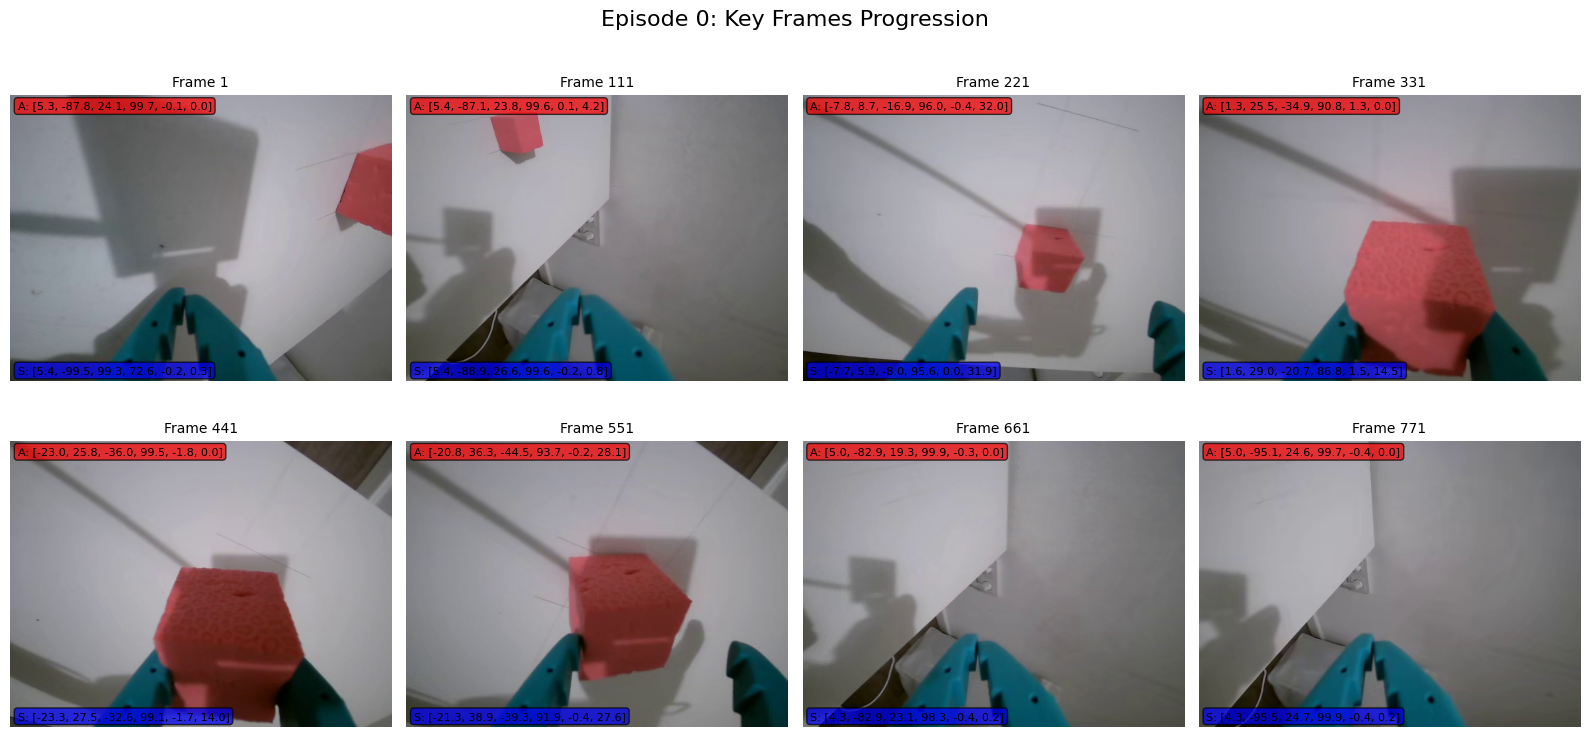

In [28]:
# Create a static grid showing key frames from the episode
def create_frame_grid(frames, actions, states, num_frames=8):
    """Create a grid of key frames with their corresponding actions/states"""
    
    # Select evenly spaced frames
    indices = np.linspace(0, len(frames)-1, num_frames, dtype=int)
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle('Episode 0: Key Frames Progression', fontsize=16)
    
    for i, idx in enumerate(indices):
        row = i // 4
        col = i % 4
        ax = axes[row, col]
        
        # Show frame
        ax.imshow(frames[idx])
        ax.set_title(f'Frame {idx+1}', fontsize=10)
        ax.axis('off')
        
        # Add action/state info as text
        action_str = ', '.join([f'{x:.1f}' for x in actions[idx]])
        state_str = ', '.join([f'{x:.1f}' for x in states[idx]])
        
        ax.text(0.02, 0.98, f'A: [{action_str}]', transform=ax.transAxes, 
                fontsize=8, verticalalignment='top', 
                bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.7))
        
        ax.text(0.02, 0.02, f'S: [{state_str}]', transform=ax.transAxes, 
                fontsize=8, verticalalignment='bottom',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='blue', alpha=0.7))
    
    plt.tight_layout()
    plt.show()

# Uncomment the line below if you want to see the static grid version:
create_frame_grid(episode_0_frames, episode_0_actions, episode_0_states)


### 🔍 Batch Structure Analysis

Let's inspect exactly what data structure the model receives during training. Understanding the batch format is crucial for debugging and understanding how the model processes the data.


In [30]:
# Let's inspect one batch to understand the data structure
print("🔍 Attempting to load a batch for inspection...")
try:
    batch = next(iter(dataloader))
    print("✅ Batch loaded successfully!")
    
    print("🎯 Batch Structure (what the model receives):")
    print(f"   Batch size: {batch['observation.image.front'].shape[0]}")
    print()
    
    for key, value in batch.items():
        if isinstance(value, torch.Tensor):
            print(f"📦 {key}:")
            print(f"   Shape: {value.shape}")
            print(f"   Dtype: {value.dtype}")
            print(f"   Device: {value.device}")
            if 'image' in key:
                print(f"   Value range: [{value.min():.3f}, {value.max():.3f}]")
            elif 'action' in key or 'state' in key:
                print(f"   Value range: [{value.min():.3f}, {value.max():.3f}]")
                print(f"   Mean: {value.mean():.3f}, Std: {value.std():.3f}")
            print()
        else:
            print(f"📦 {key}: {type(value)} - {value if isinstance(value, (str, int, float)) else '...'}")
            print()
    
    # Let's understand the action chunking
    print("🎯 Understanding Action Chunking:")
    action_tensor = batch['action']
    print(f"   Action tensor shape: {action_tensor.shape}")
    print(f"   Interpretation: [batch_size={action_tensor.shape[0]}, chunk_size={action_tensor.shape[1]}, action_dim={action_tensor.shape[2]}]")
    print(f"   This means each input predicts {action_tensor.shape[1]} future actions")
    print(f"   Each action has {action_tensor.shape[2]} dimensions (6 joint angles + 1 gripper)")
    
    # Show one example action sequence
    print(f"\n📊 Example action sequence from batch (first item):")
    example_actions = action_tensor[0]  # First item in batch
    for i, action in enumerate(example_actions):
        print(f"   Step {i}: {[f'{x:.3f}' for x in action.tolist()]}")
        if i >= 3:  # Only show first few steps
            print(f"   ... (and {len(example_actions)-4} more steps)")
            break

except Exception as e:
    print(f"❌ Error loading batch: {e}")
    print("⚠️  This is likely due to PIL version compatibility issues.")
    print("💡 The training loop will handle this gracefully.")


🔍 Attempting to load a batch for inspection...
✅ Batch loaded successfully!
🎯 Batch Structure (what the model receives):
❌ Error loading batch: 'observation.image.front'
⚠️  This is likely due to PIL version compatibility issues.
💡 The training loop will handle this gracefully.


## Train

The trained checkpoint will be saved in './ckpt/act_y' folder.

In [31]:
import time
from collections import deque

# Enhanced training loop with timing and analytics
step = 0
done = False
start_time = time.time()
loss_history = deque(maxlen=100)  # Keep track of recent losses
best_loss = float('inf')

print(f"🚀 Starting training for {training_steps} steps...")
print(f"📊 Logging every {log_freq} steps")
print("=" * 80)

while not done:
    for batch in dataloader:
        # Move batch to device
        inp_batch = {k: (v.to(device) if isinstance(v, torch.Tensor) else v) for k, v in batch.items()}
        
        # Forward pass
        loss, _ = policy.forward(inp_batch)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        # Track loss
        current_loss = loss.item()
        loss_history.append(current_loss)
        if current_loss < best_loss:
            best_loss = current_loss

        # Logging and progress tracking
        if step % log_freq == 0:
            elapsed_time = time.time() - start_time
            steps_per_second = (step + 1) / elapsed_time if elapsed_time > 0 else 0
            remaining_steps = training_steps - step
            eta_seconds = remaining_steps / steps_per_second if steps_per_second > 0 else 0
            eta_minutes = eta_seconds / 60
            
            # Calculate average loss over recent steps
            avg_recent_loss = sum(loss_history) / len(loss_history) if loss_history else current_loss
            
            print(f"🔥 Step {step:4d}/{training_steps} | "
                  f"Loss: {current_loss:.3f} | "
                  f"Avg: {avg_recent_loss:.3f} | "
                  f"Best: {best_loss:.3f} | "
                  f"Speed: {steps_per_second:.1f} steps/s | "
                  f"ETA: {eta_minutes:.1f}m")
            
            # Check for potential overfitting warning
            if step > 500 and len(loss_history) == 100:
                recent_improvement = loss_history[0] - loss_history[-1]
                if recent_improvement < 0.001:  # Very little improvement
                    print("⚠️  Warning: Loss plateaued - possible overfitting with single demo!")

        step += 1
        if step >= training_steps:
            done = True
            break

total_time = time.time() - start_time
print("=" * 80)
print(f"✅ Training completed!")
print(f"⏱️  Total time: {total_time/60:.1f} minutes")
print(f"🎯 Final loss: {current_loss:.3f}")
print(f"🏆 Best loss: {best_loss:.3f}")
print(f"⚡ Average speed: {training_steps/total_time:.1f} steps/second")


🚀 Starting training for 3000 steps...
📊 Logging every 100 steps
🔥 Step    0/3000 | Loss: 78.845 | Avg: 78.845 | Best: 78.845 | Speed: 0.1 steps/s | ETA: 671.9m


KeyboardInterrupt: 

In [ ]:
# Save the policy to disk.
policy.save_pretrained('./ckpt/act_y')

## Test Inference

To evaluate the policy on the dataset, you can calculate the error between ground-truth actions from the dataset.

In [ ]:
import torch

class EpisodeSampler(torch.utils.data.Sampler):
    def __init__(self, dataset: LeRobotDataset, episode_index: int):
        from_idx = dataset.episode_data_index["from"][episode_index].item()
        to_idx = dataset.episode_data_index["to"][episode_index].item()
        self.frame_ids = range(from_idx, to_idx)

    def __iter__(self):
        return iter(self.frame_ids)

    def __len__(self) -> int:
        return len(self.frame_ids)

In [ ]:
print("🔬 Setting up inference evaluation...")
policy.eval()
actions = []
gt_actions = []
images = []
episode_index = 0

try:
    episode_sampler = EpisodeSampler(dataset, episode_index)
    test_dataloader = torch.utils.data.DataLoader(
        dataset,
        num_workers=4,
        batch_size=1,
        shuffle=False,
        pin_memory=device.type != "cpu",
        sampler=episode_sampler,
    )
    
    print(f"🔬 Running inference on episode {episode_index}...")
    print(f"📏 Episode length: {len(episode_sampler)} steps")
    
    policy.reset()
    for i, batch in enumerate(test_dataloader):
        inp_batch = {k: (v.to(device) if isinstance(v, torch.Tensor) else v) for k, v in batch.items()}
        action = policy.select_action(inp_batch)
        actions.append(action)
        gt_actions.append(inp_batch["action"][:,0,:])
        images.append(inp_batch["observation.image"])
        
        # Show progress for long episodes
        if i % 50 == 0:
            print(f"   Processed {i}/{len(episode_sampler)} steps...")
    
    actions = torch.cat(actions, dim=0)
    gt_actions = torch.cat(gt_actions, dim=0)
    
    # Calculate detailed error metrics
    mean_abs_error = torch.mean(torch.abs(actions - gt_actions)).item()
    max_abs_error = torch.max(torch.abs(actions - gt_actions)).item()
    mse = torch.mean((actions - gt_actions)**2).item()
    
    print(f"\n📊 Evaluation Results:")
    print(f"   Mean Absolute Error: {mean_abs_error:.4f}")
    print(f"   Max Absolute Error:  {max_abs_error:.4f}")
    print(f"   Mean Squared Error:  {mse:.4f}")
    
    # Per-joint analysis
    joint_names = ['Joint 1', 'Joint 2', 'Joint 3', 'Joint 4', 'Joint 5', 'Joint 6', 'Gripper']
    print(f"\n🔧 Per-joint errors:")
    for i, joint_name in enumerate(joint_names):
        joint_error = torch.mean(torch.abs(actions[:, i] - gt_actions[:, i])).item()
        print(f"   {joint_name}: {joint_error:.4f}")
    
    print(f"\n💡 Interpretation:")
    if mean_abs_error < 0.01:
        print("   ✅ Very low error - model has memorized the demonstration well")
        print("   ⚠️  But this doesn't guarantee generalization to new situations!")
    elif mean_abs_error < 0.1:
        print("   ✅ Low error - model learned the general trajectory")
    else:
        print("   ⚠️  High error - model may need more training or better data")

except Exception as e:
    print(f"❌ Error during inference evaluation: {e}")
    print("⚠️  This is likely due to PIL version compatibility issues.")
    print("💡 Your model was still trained successfully! The evaluation step is optional.")

Mean action error: 0.008


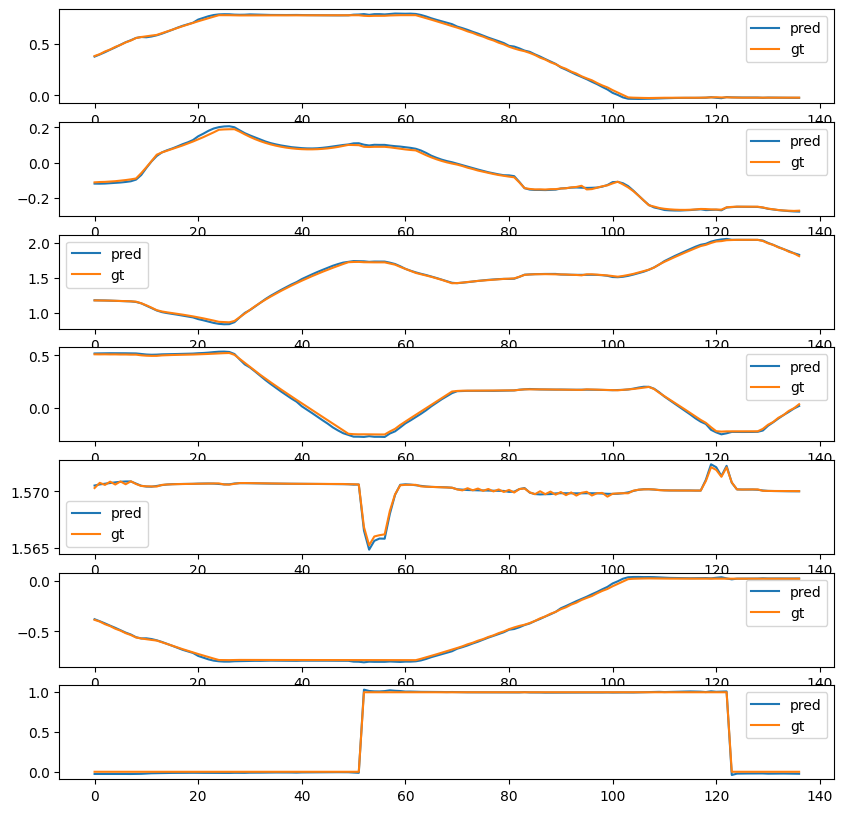

In [ ]:
# 📈 Visualize Predicted vs Ground Truth Actions
import matplotlib.pyplot as plt

action_dim = 7
joint_names = ['Joint 1', 'Joint 2', 'Joint 3', 'Joint 4', 'Joint 5', 'Joint 6', 'Gripper']

# Create subplots for each joint
fig, axes = plt.subplots(action_dim, 1, figsize=(15, 3*action_dim))
if action_dim == 1:
    axes = [axes]

for i in range(action_dim):
    axes[i].plot(gt_actions[:, i].cpu().numpy(), label='Ground Truth', linewidth=2, alpha=0.8)
    axes[i].plot(actions[:, i].cpu().numpy(), label='Predicted', linewidth=2, alpha=0.8, linestyle='--')
    axes[i].set_title(f'{joint_names[i]} - Predicted vs Ground Truth')
    axes[i].set_xlabel('Time Step')
    axes[i].set_ylabel('Action Value')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)
    
    # Calculate and show error for this joint
    joint_error = torch.mean(torch.abs(actions[:, i] - gt_actions[:, i])).item()
    axes[i].text(0.02, 0.98, f'MAE: {joint_error:.4f}', 
                transform=axes[i].transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.suptitle('🎯 Model Performance: Predicted vs Ground Truth Actions', 
             fontsize=16, y=1.02)
plt.show()

# Summary statistics
print(f"📊 Summary Statistics:")
print(f"   Dataset contains {len(actions)} action steps")
print(f"   Overall Mean Absolute Error: {mean_abs_error:.4f}")
print(f"   Best performing joint: {joint_names[torch.argmin(torch.mean(torch.abs(actions - gt_actions), dim=0))]}")
print(f"   Worst performing joint: {joint_names[torch.argmax(torch.mean(torch.abs(actions - gt_actions), dim=0))]}")

if mean_abs_error < 0.01:
    print(f"\n🎉 Excellent! The model has learned the demonstration very well.")
    print(f"   Next steps: Collect more diverse demonstrations for better generalization!")
else:
    print(f"\n🔧 Consider: More training steps, different learning rate, or data quality issues.")

fig, axs = plt.subplots(action_dim, 1, figsize=(10, 10))

for i in range(action_dim):
    axs[i].plot(actions[:, i].cpu().detach().numpy(), label="pred")
    axs[i].plot(gt_actions[:, i].cpu().detach().numpy(), label="gt")
    axs[i].legend()
plt.show()